## Chapter2.4

In [156]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import StatisticalResult

from lifelines.utils import (
    group_survival_table_from_events,
    string_rjustify,
    format_p_value,
    format_floats,
    interpolate_at_times_and_return_pandas,
    _expected_value_of_survival_up_to_t,
    _expected_value_of_survival_squared_up_to_t,
)

In [4]:
DATADIR = '../datasets/'

In [157]:
def _chisq_test_p_value(U, degrees_freedom) -> float:
    p_value = stats.chi2.sf(U, degrees_freedom)
    return p_value

In [78]:
# 検定結果をまとめる
def surv_test(durations_A, durations_B, event_observed_A, event_observed_B, t_0=-1):
    """2群間比較
    """
    #ログランク検定
    weights = None
    res_logrank = logrank_test(
        durations_A=durations_A, 
        durations_B=durations_B, 
        event_observed_A=event_observed_A, 
        event_observed_B=event_observed_B, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    )

    # Wilcoxon検定
    weights = "wilcoxon"
    res_wilcoxon = logrank_test(
        durations_A=durations_A, 
        durations_B=durations_B, 
        event_observed_A=event_observed_A, 
        event_observed_B=event_observed_B, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    )

    # Tarone-Ware検定
    weights = "tarone-ware"
    res_tarone_ware = logrank_test(
        durations_A=durations_A, 
        durations_B=durations_B, 
        event_observed_A=event_observed_A, 
        event_observed_B=event_observed_B, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    )

    # Peto-Prentice検定
    weights = "peto"
    res_peto = logrank_test(
        durations_A=durations_A, 
        durations_B=durations_B, 
        event_observed_A=event_observed_A, 
        event_observed_B=event_observed_B, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    )
    
    res = pd.DataFrame({
        "検定": [
            "ログランク", 
            "Wilcoxon", 
            "Tarone-Ware", 
            "Peto-Prentice"
        ],
        "検定統計量": [
            res_logrank._test_statistic[0], 
            res_wilcoxon._test_statistic[0], 
            res_tarone_ware._test_statistic[0], 
            res_peto._test_statistic[0]
        ],
        "p値": [
            res_logrank._p_value[0], 
            res_wilcoxon._p_value[0], 
            res_tarone_ware._p_value[0], 
            res_peto._p_value[0]
        ]
    })
    return res

## WHAS100の男女間で生存時間が異なるか検定

In [85]:
# WHAS100データセット
df_whas = pd.read_csv(os.path.join(DATADIR, 'whas100.csv'), encoding='shift-jis', index_col=0)
df_whas.head(3)

,登録日,追跡日,入院期間,追跡日数,生存状態,登録時年齢,性別,BMI
被験者番号,,,,,,,,
1,03/13/1995,03/19/1995,4,6,1,65,0,31.38134
2,01/14/1995,01/23/1996,5,374,1,88,1,22.65790
3,02/17/1995,10/04/2001,5,2421,1,77,0,27.87892


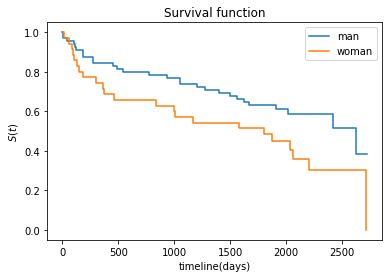

In [80]:
df_whas_man = df_whas[df_whas["性別"]==0]
df_whas_woman = df_whas[df_whas["性別"]==1]

kmf_man = KaplanMeierFitter()
kmf_man.fit(df_whas_man["追跡日数"], event_observed=df_whas_man["生存状態"])
kmf_man.plot_survival_function(ci_show=False, label="man")

kmf_woman = KaplanMeierFitter()
kmf_woman.fit(df_whas_woman["追跡日数"], event_observed=df_whas_woman["生存状態"])
kmf_woman.plot_survival_function(ci_show=False, label="woman")

plt.xlabel('timeline(days)')
plt.ylabel('$S(t)$')
plt.title('Survival function')

In [81]:
res_whas = surv_test(
    durations_A=df_whas_man["追跡日数"], 
    durations_B=df_whas_woman["追跡日数"], 
    event_observed_A=df_whas_man["生存状態"], 
    event_observed_B=df_whas_woman["生存状態"], 
    t_0=-1, # 最終の観測時間(−1の場合：全期間)
)
res_whas

,検定,検定統計量,p値
0,ログランク,3.971377,0.046280
1,Wilcoxon,3.462417,0.062778
2,Tarone-Ware,3.685975,0.054872
3,Peto-Prentice,3.850660,0.049726


## BPD試験の補充療法有無によって治療日数が異なるか検定

In [86]:
# BPD試験データセット
df_bpd = pd.read_csv(os.path.join(DATADIR, 'bpd.csv'), encoding='shift-jis', index_col=0)
df_bpd.head(3)

,surfact,ondays,censor
id,,,
1,0,59,1
2,0,514,1
3,0,313,1


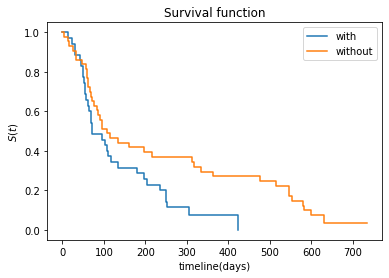

In [84]:
df_bpd_with = df_bpd[df_bpd["surfact"]==1]
df_bpd_without = df_bpd[df_bpd["surfact"]==0]

kmf_with = KaplanMeierFitter()
kmf_with.fit(df_bpd_with["ondays"], event_observed=df_bpd_with["censor"])
kmf_with.plot_survival_function(ci_show=False, label="with")

kmf_without = KaplanMeierFitter()
kmf_without.fit(df_bpd_without["ondays"], event_observed=df_bpd_without["censor"])
kmf_without.plot_survival_function(ci_show=False, label="without")

plt.xlabel('timeline(days)')
plt.ylabel('$S(t)$')
plt.title('Survival function');

In [88]:
res_bpd = surv_test(
    durations_A=df_bpd_with["ondays"], 
    durations_B=df_bpd_without["ondays"], 
    event_observed_A=df_bpd_with["censor"], 
    event_observed_B=df_bpd_without["censor"], 
    t_0=-1, # 最終の観測時間(−1の場合：全期間)
)
res_bpd

,検定,検定統計量,p値
0,ログランク,5.618023,0.017777
1,Wilcoxon,2.489843,0.114583
2,Tarone-Ware,3.698426,0.054464
3,Peto-Prentice,2.534349,0.111393


## WHAS100で年齢グループによって生存時間が異なるか検定



In [104]:
def multivariate_surv_test(event_durations, groups, event_observed, t_0=-1):
    """多群検定
    """
    #ログランク検定
    weights = None
    res_logrank = multivariate_logrank_test(
        event_durations=event_durations,
        groups=groups, 
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 

    # Wilcoxon検定
    weights = "wilcoxon"
    res_wilcoxon = multivariate_logrank_test(
        event_durations=event_durations,
        groups=groups, 
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 

    # Tarone-Ware検定
    weights = "tarone-ware"
    res_tarone_ware = multivariate_logrank_test(
        event_durations=event_durations,
        groups=groups, 
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 

    # Peto-Prentice検定
    weights = "peto"
    res_peto = multivariate_logrank_test(
        event_durations=event_durations,
        groups=groups, 
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 
    
    res = pd.DataFrame({
        "検定": [
            "ログランク", 
            "Wilcoxon", 
            "Tarone-Ware", 
            "Peto-Prentice"
        ],
        "検定統計量": [
            res_logrank._test_statistic[0], 
            res_wilcoxon._test_statistic[0], 
            res_tarone_ware._test_statistic[0], 
            res_peto._test_statistic[0]
        ],
        "自由度": [
            res_logrank.degrees_of_freedom, 
            res_wilcoxon.degrees_of_freedom, 
            res_tarone_ware.degrees_of_freedom, 
            res_peto.degrees_of_freedom
        ],
        "p値": [
            res_logrank._p_value[0], 
            res_wilcoxon._p_value[0], 
            res_tarone_ware._p_value[0], 
            res_peto._p_value[0]
        ]
    })
    return res

In [90]:
df_whas.head(3)

,登録日,追跡日,入院期間,追跡日数,生存状態,登録時年齢,性別,BMI
被験者番号,,,,,,,,
1,03/13/1995,03/19/1995,4,6,1,65,0,31.38134
2,01/14/1995,01/23/1996,5,374,1,88,1,22.65790
3,02/17/1995,10/04/2001,5,2421,1,77,0,27.87892


In [96]:
def get_age_group(age):
    if age<60:
        return "<60"
    elif (60<=age) & (age<=69):
        return "60-69"
    elif (70<=age) & (age<=79):
        return "70-79"
    elif 80<=age:
        return "80<="

Text(0.5, 1.0, 'Survival function')

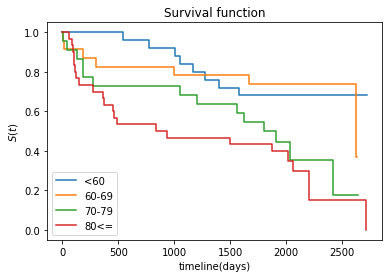

In [93]:
df_whas_0_60 = df_whas[df_whas["登録時年齢"]<60]
df_whas_60_69 = df_whas[(60<=df_whas["登録時年齢"]) & (df_whas["登録時年齢"]<=69)]
df_whas_70_79 = df_whas[(70<=df_whas["登録時年齢"]) & (df_whas["登録時年齢"]<=79)]
df_whas_80_inf = df_whas[80<=df_whas["登録時年齢"]]

kmf_0_60 = KaplanMeierFitter()
kmf_0_60.fit(df_whas_0_60["追跡日数"], event_observed=df_whas_0_60["生存状態"])
kmf_0_60.plot_survival_function(ci_show=False, label="<60")

kmf_60_69 = KaplanMeierFitter()
kmf_60_69.fit(df_whas_60_69["追跡日数"], event_observed=df_whas_60_69["生存状態"])
kmf_60_69.plot_survival_function(ci_show=False, label="60-69")

kmf_70_79 = KaplanMeierFitter()
kmf_70_79.fit(df_whas_70_79["追跡日数"], event_observed=df_whas_70_79["生存状態"])
kmf_70_79.plot_survival_function(ci_show=False, label="70-79")

kmf_80_inf = KaplanMeierFitter()
kmf_80_inf.fit(df_whas_80_inf["追跡日数"], event_observed=df_whas_80_inf["生存状態"])
kmf_80_inf.plot_survival_function(ci_show=False, label="80<=")

plt.xlabel('timeline(days)')
plt.ylabel('$S(t)$')
plt.title('Survival function')

In [98]:
df_whas["group"] = df_whas["登録時年齢"].apply(get_age_group)

In [200]:
res_whas_group = multivariate_surv_test(
    event_durations=df_whas["追跡日数"],
    groups=df_whas["group"], 
    event_observed=df_whas["生存状態"], 
    t_0=-1, #最終の観測時間(−1の場合：全期間)
) 
res_whas_group

,検定,検定統計量,自由度,p値
0,ログランク,15.572118,3,0.001388
1,Wilcoxon,12.298105,3,0.006429
2,Tarone-Ware,13.519888,3,0.003637
3,Peto-Prentice,14.535240,3,0.002260


## WHAS100の年齢グループによる生存時間の傾向性検定

In [194]:
def multivariate_logrank_trend_test(
    event_durations, groups, trends, event_observed=None, t_0=-1, weightings=None, **kwargs
):  # pylint: disable=too-many-locals
    r"""
    This test is a generalization of the logrank_test: it can deal with n>2 populations (and should
    be equal when n=2):

    .. math::
        \begin{align}
         & H_0: h_1(t) = h_2(t) = h_3(t) = ... = h_n(t) \\
         & H_A: \text{there exist at least one group that differs from the other.}
        \end{align}


    Parameters
    ----------

    event_durations: iterable
        a (n,) list-like representing the (possibly partial) durations of all individuals

    groups: iterable
        a (n,) list-like of unique group labels for each individual.

    event_observed: iterable, optional
        a (n,) list-like of event_observed events: 1 if observed death, 0 if censored. Defaults to all observed.

    t_0: float, optional (default=-1)
        the period under observation, -1 for all time.

    weightings: str, optional
        apply a weighted logrank test: options are "wilcoxon" for Wilcoxon (also known as Breslow), "tarone-ware"
        for Tarone-Ware, "peto" for Peto test and "fleming-harrington" for Fleming-Harrington test.
        These are useful for testing for early or late differences in the survival curve. For the Fleming-Harrington
        test, keyword arguments p and q must also be provided with non-negative values.

        Weightings are applied at the ith ordered failure time, :math:`t_{i}`, according to:
            Wilcoxon: :math:`n_i`
            Tarone-Ware: :math:`\sqrt{n_i}`
            Peto: :math:`\bar{S}(t_i)`
            Fleming-Harrington: :math:`\hat{S}(t_i)^p \times (1 - \hat{S}(t_i))^q`

            where :math:`n_i` is the number at risk just prior to time :math:`t_{i}`, :math:`\bar{S}(t_i)` is
            Peto-Peto's modified survival estimate and :math:`\hat{S}(t_i)` is the left-continuous
            Kaplan-Meier survival estimate at time :math:`t_{i}`.

    kwargs:
        add keywords and meta-data to the experiment summary.


    Returns
    -------

    StatisticalResult
       a StatisticalResult object with properties ``p_value``, ``summary``, ``test_statistic``, ``print_summary``

    Examples
    --------

    .. code:: python

        df = pd.DataFrame({
           'durations': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
           'events': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
           'groups': [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]
        })
        result = multivariate_logrank_test(df['durations'], df['groups'], df['events'])
        result.test_statistic
        result.p_value
        result.print_summary()


        # numpy example
        G = [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]
        T = [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7]
        E = [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
        result = multivariate_logrank_test(T, G, E)
        result.test_statistic


    See Also
    --------
    pairwise_logrank_test
    logrank_test
    """
    kwargs.setdefault("test_name", "multivariate_logrank_trend_test")

    event_durations, groups = np.asarray(event_durations), np.asarray(groups)
    if event_observed is None:
        event_observed = np.ones((event_durations.shape[0], 1))
    else:
        event_observed = np.asarray(event_observed)

    n = np.max(event_durations.shape)
    assert n == np.max(event_durations.shape) == np.max(event_observed.shape), "inputs must be of the same length."
    groups, event_durations, event_observed = map(
        lambda x: pd.Series(np.asarray(x).reshape(n)), [groups, event_durations, event_observed]
    )

    unique_groups, rm, obs, _ = group_survival_table_from_events(groups, event_durations, event_observed, limit=t_0)
    n_groups = unique_groups.shape[0]

    # compute the factors needed
    n_ij = rm.sum(0).values - rm.cumsum(0).shift(1).fillna(0)
    d_i = obs.sum(1)
    n_i = rm.values.sum() - rm.sum(1).cumsum().shift(1).fillna(0)
    ev_i = n_ij.mul(d_i / n_i, axis="index")
    
    c = np.array(trends).reshape(len(trends),1)

    # compute weightings for log-rank alternatives
    if weightings is None:
        w_i = np.ones(d_i.shape[0])
    elif weightings == "wilcoxon":
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Wilcoxon")
        w_i = n_i
    elif weightings == "tarone-ware":
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Tarone-Ware")
        w_i = np.sqrt(n_i)
    elif weightings == "peto":
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Peto")
        w_i = np.cumprod(1.0 - (ev_i.sum(1)) / (n_i + 1))  # Peto-Peto's modified survival estimates.
    elif weightings == "fleming-harrington":
        if "p" in kwargs:
            p = kwargs["p"]
            if p < 0:
                raise ValueError("p must be non-negative.")
        else:
            raise ValueError("Must provide keyword argument p for Flemington-Harrington test statistic")
        if "q" in kwargs:
            q = kwargs["q"]
            if q < 0:
                raise ValueError("q must be non-negative.")
        else:
            raise ValueError("Must provide keyword argument q for Flemington-Harrington test statistic")
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Flemington-Harrington")
        kmf = KaplanMeierFitter().fit(event_durations, event_observed=event_observed)
        s = kmf.survival_function_.to_numpy().flatten()[:-1]  # Left-continuous Kaplan-Meier survival estimate.
        w_i = np.power(s, p) * np.power(1.0 - s, q)
    else:
        raise ValueError("Invalid value for weightings.")

    # apply weights to observed and expected
    N_j = obs.mul(w_i, axis=0).sum(0).values
    ev = ev_i.mul(w_i, axis=0).sum(0)

    # vector of observed minus expected
    Z_j = N_j - ev

    assert abs(Z_j.sum()) < 10e-8, "Sum is not zero."  # this should move to a test eventually.

    # compute covariance matrix
    factor = (((n_i - d_i) / (n_i - 1)).replace([np.inf, np.nan], 1)) * d_i / n_i ** 2
    n_ij["_"] = n_i.values
    V_ = (n_ij.mul(w_i, axis=0)).mul(np.sqrt(factor), axis="index").fillna(0)  # weighted V_
    V = -np.dot(V_.T, V_)
    ix = np.arange(n_groups)
    V[ix, ix] = V[ix, ix] - V[-1, ix]
    V = V[:-1, :-1]

    # take the first n-1 groups
    #U = Z_j.iloc[:-1] @ np.linalg.pinv(V[:-1, :-1]) @ Z_j.iloc[:-1]  # Z.T*inv(V)*Z
    U = (c.T @ Z_j.values.reshape(len(Z_j), 1) @ Z_j.values.reshape(1, len(Z_j)) @ c) / (c.T @ V @ c)

    # compute the p-values and tests
    p_value = _chisq_test_p_value(U[0], 1)
    return StatisticalResult(p_value, U[0], t_0=t_0, null_distribution="chi squared", degrees_of_freedom=1, **kwargs)

In [195]:
def multivariate_surv_trend_test(event_durations, groups, trends, event_observed, t_0=-1):
    """多群検定
    """
    #ログランク検定
    weights = None
    res_logrank = multivariate_logrank_trend_test(
        event_durations=event_durations,
        groups=groups, 
        trends=trends,
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 

    # Wilcoxon検定
    weights = "wilcoxon"
    res_wilcoxon = multivariate_logrank_trend_test(
        event_durations=event_durations,
        groups=groups,  
        trends=trends,
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 

    # Tarone-Ware検定
    weights = "tarone-ware"
    res_tarone_ware = multivariate_logrank_trend_test(
        event_durations=event_durations,
        groups=groups,  
        trends=trends,
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 

    # Peto-Prentice検定
    weights = "peto"
    res_peto = multivariate_logrank_trend_test(
        event_durations=event_durations,
        groups=groups,  
        trends=trends,
        event_observed=event_observed, 
        t_0=t_0, #最終の観測時間(−1の場合：全期間)
        weightings=weights
    ) 
    
    res = pd.DataFrame({
        "検定": [
            "ログランク", 
            "Wilcoxon", 
            "Tarone-Ware", 
            "Peto-Prentice"
        ],
        "検定統計量": [
            res_logrank._test_statistic[0], 
            res_wilcoxon._test_statistic[0], 
            res_tarone_ware._test_statistic[0], 
            res_peto._test_statistic[0]
        ],
        "自由度": [
            res_logrank.degrees_of_freedom, 
            res_wilcoxon.degrees_of_freedom, 
            res_tarone_ware.degrees_of_freedom, 
            res_peto.degrees_of_freedom
        ],
        "p値": [
            res_logrank._p_value[0], 
            res_wilcoxon._p_value[0], 
            res_tarone_ware._p_value[0], 
            res_peto._p_value[0]
        ]
    })
    return res

In [201]:
df_whas["group"].unique()
#groups.unique()のgroup名の順序と同じ順序でトレンドを入力する必要がある

array(['60-69', '80<=', '70-79', '<60'], dtype=object)

In [202]:
res_whas_group_trend = multivariate_surv_trend_test(
    event_durations=df_whas["追跡日数"],
    groups=df_whas["group"], 
    trends=[65, 86, 75, 46], #groups.unique()のgroup名の順序と同じ順序でトレンドを入力する
    event_observed=df_whas["生存状態"], 
    t_0=-1, #最終の観測時間(−1の場合：全期間)
) 
res_whas_group_trend

,検定,検定統計量,自由度,p値
0,ログランク,12.438786,1,0.000421
1,Wilcoxon,9.987026,1,0.001576
2,Tarone-Ware,10.700715,1,0.001071
3,Peto-Prentice,12.077149,1,0.000510


### 参考

In [110]:
# 参考 他群間比較
def multivariate_logrank_test(
    event_durations, groups, event_observed=None, t_0=-1, weightings=None, **kwargs
) -> StatisticalResult:  # pylint: disable=too-many-locals
    r"""
    This test is a generalization of the logrank_test: it can deal with n>2 populations (and should
    be equal when n=2):

    .. math::
        \begin{align}
         & H_0: h_1(t) = h_2(t) = h_3(t) = ... = h_n(t) \\
         & H_A: \text{there exist at least one group that differs from the other.}
        \end{align}


    Parameters
    ----------

    event_durations: iterable
        a (n,) list-like representing the (possibly partial) durations of all individuals

    groups: iterable
        a (n,) list-like of unique group labels for each individual.

    event_observed: iterable, optional
        a (n,) list-like of event_observed events: 1 if observed death, 0 if censored. Defaults to all observed.

    t_0: float, optional (default=-1)
        the period under observation, -1 for all time.

    weightings: str, optional
        apply a weighted logrank test: options are "wilcoxon" for Wilcoxon (also known as Breslow), "tarone-ware"
        for Tarone-Ware, "peto" for Peto test and "fleming-harrington" for Fleming-Harrington test.
        These are useful for testing for early or late differences in the survival curve. For the Fleming-Harrington
        test, keyword arguments p and q must also be provided with non-negative values.

        Weightings are applied at the ith ordered failure time, :math:`t_{i}`, according to:
            Wilcoxon: :math:`n_i`
            Tarone-Ware: :math:`\sqrt{n_i}`
            Peto: :math:`\bar{S}(t_i)`
            Fleming-Harrington: :math:`\hat{S}(t_i)^p \times (1 - \hat{S}(t_i))^q`

            where :math:`n_i` is the number at risk just prior to time :math:`t_{i}`, :math:`\bar{S}(t_i)` is
            Peto-Peto's modified survival estimate and :math:`\hat{S}(t_i)` is the left-continuous
            Kaplan-Meier survival estimate at time :math:`t_{i}`.

    kwargs:
        add keywords and meta-data to the experiment summary.


    Returns
    -------

    StatisticalResult
       a StatisticalResult object with properties ``p_value``, ``summary``, ``test_statistic``, ``print_summary``

    Examples
    --------

    .. code:: python

        df = pd.DataFrame({
           'durations': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
           'events': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
           'groups': [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]
        })
        result = multivariate_logrank_test(df['durations'], df['groups'], df['events'])
        result.test_statistic
        result.p_value
        result.print_summary()


        # numpy example
        G = [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2]
        T = [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7]
        E = [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
        result = multivariate_logrank_test(T, G, E)
        result.test_statistic


    See Also
    --------
    pairwise_logrank_test
    logrank_test
    """
    kwargs.setdefault("test_name", "multivariate_logrank_test")

    event_durations, groups = np.asarray(event_durations), np.asarray(groups)
    if event_observed is None:
        event_observed = np.ones((event_durations.shape[0], 1))
    else:
        event_observed = np.asarray(event_observed)

    n = np.max(event_durations.shape)
    assert n == np.max(event_durations.shape) == np.max(event_observed.shape), "inputs must be of the same length."
    groups, event_durations, event_observed = map(
        lambda x: pd.Series(np.asarray(x).reshape(n)), [groups, event_durations, event_observed]
    )

    unique_groups, rm, obs, _ = group_survival_table_from_events(groups, event_durations, event_observed, limit=t_0)
    n_groups = unique_groups.shape[0]

    # compute the factors needed
    n_ij = rm.sum(0).values - rm.cumsum(0).shift(1).fillna(0)
    d_i = obs.sum(1)
    n_i = rm.values.sum() - rm.sum(1).cumsum().shift(1).fillna(0)
    ev_i = n_ij.mul(d_i / n_i, axis="index")

    # compute weightings for log-rank alternatives
    if weightings is None:
        w_i = np.ones(d_i.shape[0])
    elif weightings == "wilcoxon":
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Wilcoxon")
        w_i = n_i
    elif weightings == "tarone-ware":
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Tarone-Ware")
        w_i = np.sqrt(n_i)
    elif weightings == "peto":
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Peto")
        w_i = np.cumprod(1.0 - (ev_i.sum(1)) / (n_i + 1))  # Peto-Peto's modified survival estimates.
    elif weightings == "fleming-harrington":
        if "p" in kwargs:
            p = kwargs["p"]
            if p < 0:
                raise ValueError("p must be non-negative.")
        else:
            raise ValueError("Must provide keyword argument p for Flemington-Harrington test statistic")
        if "q" in kwargs:
            q = kwargs["q"]
            if q < 0:
                raise ValueError("q must be non-negative.")
        else:
            raise ValueError("Must provide keyword argument q for Flemington-Harrington test statistic")
        kwargs["test_name"] = kwargs["test_name"].replace("logrank", "Flemington-Harrington")
        kmf = KaplanMeierFitter().fit(event_durations, event_observed=event_observed)
        s = kmf.survival_function_.to_numpy().flatten()[:-1]  # Left-continuous Kaplan-Meier survival estimate.
        w_i = np.power(s, p) * np.power(1.0 - s, q)
    else:
        raise ValueError("Invalid value for weightings.")

    # apply weights to observed and expected
    N_j = obs.mul(w_i, axis=0).sum(0).values
    ev = ev_i.mul(w_i, axis=0).sum(0)

    # vector of observed minus expected
    Z_j = N_j - ev

    assert abs(Z_j.sum()) < 10e-8, "Sum is not zero."  # this should move to a test eventually.

    # compute covariance matrix
    factor = (((n_i - d_i) / (n_i - 1)).replace([np.inf, np.nan], 1)) * d_i / n_i ** 2
    n_ij["_"] = n_i.values
    V_ = (n_ij.mul(w_i, axis=0)).mul(np.sqrt(factor), axis="index").fillna(0)  # weighted V_
    V = -np.dot(V_.T, V_)
    ix = np.arange(n_groups)
    V[ix, ix] = V[ix, ix] - V[-1, ix]
    V = V[:-1, :-1]

    # take the first n-1 groups
    U = Z_j.iloc[:-1] @ np.linalg.pinv(V[:-1, :-1]) @ Z_j.iloc[:-1]  # Z.T*inv(V)*Z

    # compute the p-values and tests
    p_value = _chisq_test_p_value(U, n_groups - 1)
    return StatisticalResult(p_value, U, t_0=t_0, null_distribution="chi squared", degrees_of_freedom=n_groups - 1, **kwargs)

Signature:
multivariate_logrank_test(
    event_durations,
    groups,
    event_observed=None,
    t_0=-1,
    weightings=None,
    **kwargs,
) -> lifelines.statistics.StatisticalResult
Source:   
def multivariate_logrank_test(
    event_durations, groups, event_observed=None, t_0=-1, weightings=None, **kwargs
) -> StatisticalResult:  # pylint: disable=too-many-locals
    r"""
    This test is a generalization of the logrank_test: it can deal with n>2 populations (and should
    be equal when n=2):

    .. math::
        \begin{align}
         & H_0: h_1(t) = h_2(t) = h_3(t) = ... = h_n(t) \\
         & H_A: \text{there exist at least one group that differs from the other.}
        \end{align}


    Parameters
    ----------

    event_durations: iterable
        a (n,) list-like representing the (possibly partial) durations of all individuals

    groups: iterable
        a (n,) list-like of unique group labels for each individual.

    event_observed: iterable, optional
        a (n